<a href="https://colab.research.google.com/github/molo-biloa/Exam-Group14-YIBS-2025/blob/main/Exam_Group14_YIBS_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


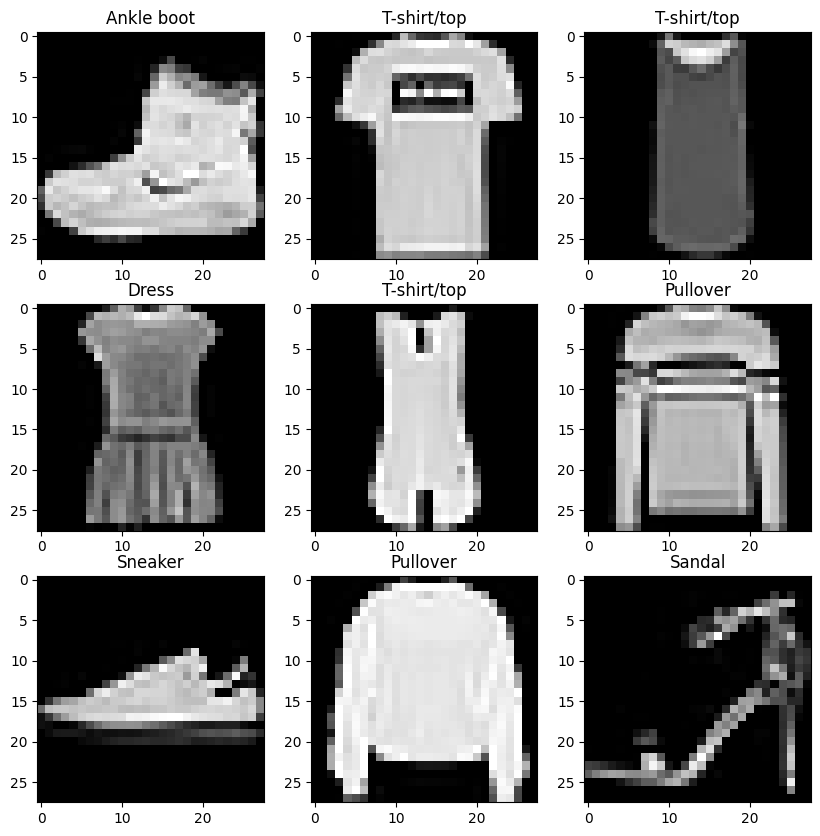

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.6854 - loss: 0.8872 - val_accuracy: 0.8497 - val_loss: 0.4052
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.8380 - loss: 0.4452 - val_accuracy: 0.8741 - val_loss: 0.3365
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 55ms/step - accuracy: 0.8600 - loss: 0.3850 - val_accuracy: 0.8821 - val_loss: 0.3192
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.8772 - loss: 0.3374 - val_accuracy: 0.8958 - val_loss: 0.2858
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.8869 - loss: 0.3144 - val_accuracy: 0.9004 - val_loss: 0.2672
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.8925 - loss: 0.2914 - val_accuracy: 0.9048 - val_loss: 0.2607
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - accuracy: 0.9005 - loss: 0.2727 - val_accuracy: 0.9030 - val_loss: 0.2576
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.9051 - loss: 0.2592 - 

Test accuracy: 0.91


In [ ]:
# Install Kaggle API for dataset download
!pip install -q kagglehub

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Download Fashion-MNIST dataset
path = kagglehub.dataset_download("zalando-research/fashionmnist")

# Load dataset using Keras (alternative if Kaggle download fails)
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Explore dataset
print(f"Training data shape: {train_images.shape}")  # (60000, 28, 28)
print(f"Test data shape: {test_images.shape}")       # (10000, 28, 28)

# Plot sample images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(class_names[train_labels[i]])
plt.show()

# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape for CNN input (add channel dimension)
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10,
                    validation_split=0.2, batch_size=64)

# Evaluate
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.2f}")

# Save model
model.save('fashion_mnist_cnn.h5')

In [ ]:
ls

fashion_mnist_cnn.h5    fashion-mnist_train.csv  t10k-labels-idx1-ubyte   train-labels-idx1-ubyte
fashion-mnist_test.csv  t10k-images-idx3-ubyte   train-images-idx3-ubyte


In [ ]:
cd ../


/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions


In [ ]:
ls

4/


In [ ]:
cd 4

/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [ ]:
ls

fashion_mnist_cnn.h5    fashion-mnist_train.csv  t10k-labels-idx1-ubyte   train-labels-idx1-ubyte
fashion-mnist_test.csv  t10k-images-idx3-ubyte   train-images-idx3-ubyte


In [ ]:
from google.colab import files
files.download("fashion_mnist_cnn.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

100%|██████████| 68.8M/68.8M [00:00<00:00, 147MB/s]

Extracting files...


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.24MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training data shape: (60000, 28, 28)
Test data shape: torch.Size([10000, 28, 28])


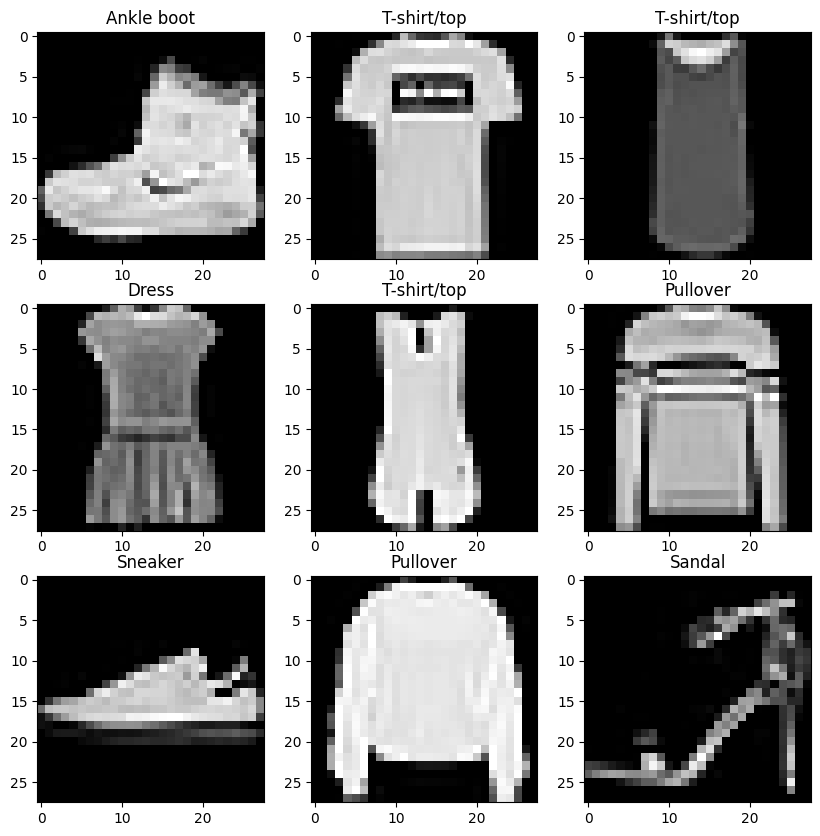


Epoch 1/10
--------------------
  Batch 100/938: Loss: 1.2123 | Accuracy: 56.52%
  Batch 200/938: Loss: 0.9722 | Accuracy: 64.67%
  Batch 300/938: Loss: 0.8625 | Accuracy: 68.19%
  Batch 400/938: Loss: 0.7918 | Accuracy: 70.72%
  Batch 500/938: Loss: 0.7456 | Accuracy: 72.39%
  Batch 600/938: Loss: 0.7141 | Accuracy: 73.55%
  Batch 700/938: Loss: 0.6877 | Accuracy: 74.58%
  Batch 800/938: Loss: 0.6639 | Accuracy: 75.55%
  Batch 900/938: Loss: 0.6431 | Accuracy: 76.38%

Epoch 1 Summary:
  Training Loss: 0.6377 | Training Accuracy: 76.60%
  Validation Loss: 0.4148 | Validation Accuracy: 84.33%
--------------------------------------------------

Epoch 2/10
--------------------
  Batch 100/938: Loss: 0.4723 | Accuracy: 83.27%
  Batch 200/938: Loss: 0.4612 | Accuracy: 83.23%
  Batch 300/938: Loss: 0.4600 | Accuracy: 83.32%
  Batch 400/938: Loss: 0.4544 | Accuracy: 83.56%
  Batch 500/938: Loss: 0.4488 | Accuracy: 83.84%
  Batch 600/938: Loss: 0.4442 | Accuracy: 83.98%
  Batch 700/938: Loss:

In [ ]:
# Install required libraries
!pip install torch torchvision matplotlib kagglehub

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import kagglehub

# Download Fashion-MNIST dataset
path = kagglehub.dataset_download("zalando-research/fashionmnist")

# Load dataset using PyTorch
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Convert to numpy arrays for visualization
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()

# Explore dataset
print(f"Training data shape: {train_images.shape}")  # (60000, 28, 28)
print(f"Test data shape: {test_data.data.shape}")    # (10000, 28, 28)

# Plot sample images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(class_names[train_labels[i]])
plt.show()

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),    # (32, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (32, 13, 13)
            nn.Conv2d(32, 64, kernel_size=3),  # (64, 11, 11)
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (64, 5, 5)
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop with detailed logging
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 20)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Print every 100 batches
        if (batch_idx + 1) % 100 == 0:
            current_loss = running_loss / total
            current_acc = 100 * correct / total
            print(f"  Batch {batch_idx+1}/{len(train_loader)}: "
                  f"Loss: {current_loss:.4f} | "
                  f"Accuracy: {current_acc:.2f}%")

    # Epoch statistics
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Training Loss: {epoch_loss:.4f} | "
          f"Training Accuracy: {epoch_acc:.2f}%")

    # Validation phase (optional)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:  # Using test set for demonstration
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = 100 * val_correct / val_total
    print(f"  Validation Loss: {val_loss:.4f} | "
          f"Validation Accuracy: {val_acc:.2f}%")
    print("-" * 50)

# Final evaluation
model.eval()
final_correct = 0
final_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

print("\nFinal Test Results:")
print("-" * 50)
print(f"Test Accuracy: {100 * final_correct / final_total:.2f}%")

# Save model
torch.save(model.state_dict(), 'fashion_mnist_cnn_v2.pth')
print("\nModel saved successfully!")

In [ ]:
ls

data/                  fashion-mnist_test.csv   t10k-labels-idx1-ubyte
fashion_mnist_cnn.h5   fashion-mnist_train.csv  train-images-idx3-ubyte
fashion_mnist_cnn.pth  t10k-images-idx3-ubyte   train-labels-idx1-ubyte


In [ ]:
from google.colab import files
files.download("fashion_mnist_cnn.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install required libraries
!pip install torch torchvision matplotlib kagglehub numpy

100%|██████████| 68.8M/68.8M [00:02<00:00, 29.5MB/s]

Extracting files...


100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 5.96MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 52.9MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.67MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Training data shape: (60000, 28, 28)
Test data shape: torch.Size([10000, 28, 28])


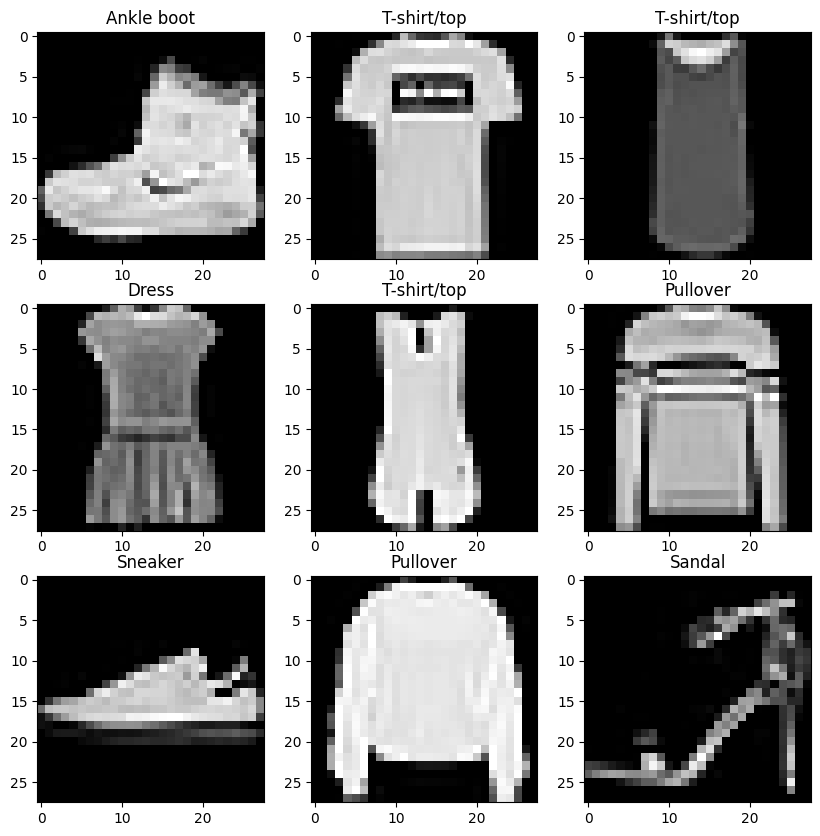


Epoch 1/10
--------------------
  Batch 100/938: Loss: 1.2393 | Accuracy: 55.64%
  Batch 200/938: Loss: 0.9856 | Accuracy: 63.97%
  Batch 300/938: Loss: 0.8763 | Accuracy: 68.01%
  Batch 400/938: Loss: 0.8127 | Accuracy: 70.16%
  Batch 500/938: Loss: 0.7686 | Accuracy: 71.72%
  Batch 600/938: Loss: 0.7355 | Accuracy: 72.97%
  Batch 700/938: Loss: 0.7055 | Accuracy: 74.08%
  Batch 800/938: Loss: 0.6832 | Accuracy: 74.94%
  Batch 900/938: Loss: 0.6637 | Accuracy: 75.70%

Epoch 1 Summary:
  Training Loss: 0.6550 | Training Accuracy: 76.02%
  Validation Loss: 0.4278 | Validation Accuracy: 84.66%
--------------------------------------------------

Epoch 2/10
--------------------
  Batch 100/938: Loss: 0.4689 | Accuracy: 83.12%
  Batch 200/938: Loss: 0.4724 | Accuracy: 82.92%
  Batch 300/938: Loss: 0.4702 | Accuracy: 83.07%
  Batch 400/938: Loss: 0.4658 | Accuracy: 83.21%
  Batch 500/938: Loss: 0.4640 | Accuracy: 83.33%
  Batch 600/938: Loss: 0.4598 | Accuracy: 83.56%
  Batch 700/938: Loss:

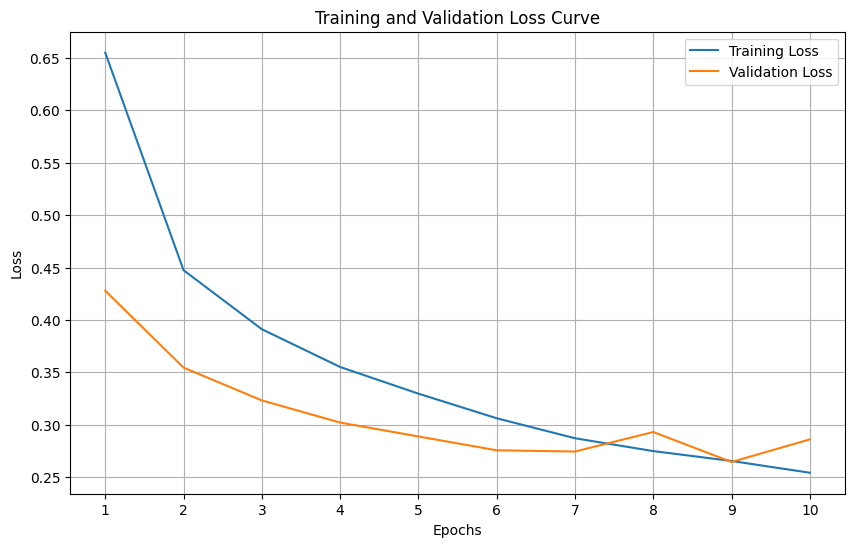


Final Test Results:
--------------------------------------------------
Test Accuracy: 90.13%

Model saved successfully!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import kagglehub

# Download Fashion-MNIST dataset
path = kagglehub.dataset_download("zalando-research/fashionmnist")

# Load dataset using PyTorch
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Convert to numpy arrays for visualization
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()

# Explore dataset
print(f"Training data shape: {train_images.shape}")  # (60000, 28, 28)
print(f"Test data shape: {test_data.data.shape}")    # (10000, 28, 28)

# Plot sample images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(class_names[train_labels[i]])
plt.show()

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),    # (32, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (32, 13, 13)
            nn.Conv2d(32, 64, kernel_size=3),  # (64, 11, 11)
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (64, 5, 5)
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop with detailed logging
epochs = 10
train_losses = []  # Store training losses
val_losses = []    # Store validation losses

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 20)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Print every 100 batches
        if (batch_idx + 1) % 100 == 0:
            current_loss = running_loss / total
            current_acc = 100 * correct / total
            print(f"  Batch {batch_idx+1}/{len(train_loader)}: "
                  f"Loss: {current_loss:.4f} | "
                  f"Accuracy: {current_acc:.2f}%")

    # Store training loss
    epoch_loss = running_loss / total
    train_losses.append(epoch_loss)

    # Epoch statistics
    epoch_acc = 100 * correct / total
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Training Loss: {epoch_loss:.4f} | "
          f"Training Accuracy: {epoch_acc:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Store validation loss
    val_loss = val_loss / val_total
    val_losses.append(val_loss)

    val_acc = 100 * val_correct / val_total
    print(f"  Validation Loss: {val_loss:.4f} | "
          f"Validation Accuracy: {val_acc:.2f}%")
    print("-" * 50)

# Generate loss chart after training
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation
model.eval()
final_correct = 0
final_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

print("\nFinal Test Results:")
print("-" * 50)
print(f"Test Accuracy: {100 * final_correct / final_total:.2f}%")

# Save model
torch.save(model.state_dict(), 'fashion_mnist_cnn_v2.pth')
print("\nModel saved successfully!")

In [2]:
ls

data/  fashion_mnist_cnn_v2.pth  sample_data/
